In [1]:
!python3 -m pip install --upgrade 'sqlalchemy < 2.0'

import pandas as pd

ЌҐ г¤ Ґвбп ­ ©вЁ гЄ § ­­л© д ©«.


Загрузим посты и обработаем их, сделав "эмбеддинги" через tfidf

In [2]:
### Загрузим посты

posts_info = pd.read_sql(
    """
      SELECT *
      FROM public.post_text_df
    """,

    con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml"
)

posts_info.head()

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business
2,3,Asian quake hits European shares\n\nShares in ...,business
3,4,India power shares jump on debut\n\nShares in ...,business
4,5,Lacroix label bought by US firm\n\nLuxury good...,business


In [3]:
import re
import string
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download("wordnet")
wnl = nltk.stem.WordNetLemmatizer()

def preprocessing(line, token=wnl):
    line = line.lower()
    line = re.sub(r"[{}]".format(string.punctuation), " ", line)
    line = line.replace('\n\n', ' ').replace('\n', ' ')
    line = ' '.join([token.lemmatize(x) for x in line.split(' ')])
    return line


tfidf = TfidfVectorizer(
    stop_words='english',
    preprocessor=preprocessing
)

tfidf

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mihalev\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


TfidfVectorizer(preprocessor=<function preprocessing at 0x0000017D196BED30>,
                stop_words='english')

In [4]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\mihalev\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [5]:
tfidf_data = (
    tfidf
    .fit_transform(posts_info['text'])
    .toarray()
)

tfidf_data = pd.DataFrame(
    tfidf_data,
    index=posts_info.post_id,
    columns=tfidf.get_feature_names_out()
)

### Генерим фичи на основе TfIdf

posts_info['TotalTfIdf'] = tfidf_data.sum(axis=1).reset_index()[0]
posts_info['MaxTfIdf'] = tfidf_data.max(axis=1).reset_index()[0]
posts_info['MeanTfIdf'] = tfidf_data.mean(axis=1).reset_index()[0]

### Пытаемся кластеризовать тексты

from sklearn.decomposition import PCA

centered = tfidf_data - tfidf_data.mean()

pca = PCA(n_components=20)
pca_decomp = pca.fit_transform(centered)

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=15, random_state=0).fit(pca_decomp)

posts_info['TextCluster'] = kmeans.labels_

dists_columns = ['DistanceTo1thCluster',
                 'DistanceTo2thCluster',
                 'DistanceTo3thCluster',
                 'DistanceTo4thCluster',
                 'DistanceTo5thCluster',
                 'DistanceTo6thCluster',
                 'DistanceTo7thCluster',
                 'DistanceTo8thCluster',
                 'DistanceTo9thCluster',
                 'DistanceTo10thCluster',
                 'DistanceTo11thCluster',
                 'DistanceTo12thCluster',
                 'DistanceTo13thCluster',
                 'DistanceTo14thCluster',
                 'DistanceTo15thCluster']

dists_df = pd.DataFrame(
    data=kmeans.transform(pca_decomp),
    columns=dists_columns
)

dists_df.head()

C:\Users\mihalev\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'wa'] not in stop_words.
  warnings.warn(


,DistanceTo1thCluster,DistanceTo2thCluster,DistanceTo3thCluster,DistanceTo4thCluster,DistanceTo5thCluster,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster,DistanceTo9thCluster,DistanceTo10thCluster,DistanceTo11thCluster,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster
0,0.478072,0.384884,0.432039,0.464252,0.445934,0.579638,0.133477,0.501140,0.444033,0.546014,0.516715,0.537311,0.499525,0.453847,0.440407
1,0.343143,0.196234,0.159481,0.330302,0.286553,0.347658,0.268154,0.377636,0.304594,0.453629,0.395200,0.434699,0.424133,0.301479,0.295810
2,0.361747,0.213343,0.335378,0.354597,0.322602,0.539058,0.142076,0.389177,0.323988,0.481675,0.426117,0.453492,0.429643,0.343141,0.314622
3,0.319020,0.127776,0.264212,0.293121,0.281042,0.496258,0.240267,0.351343,0.264274,0.445385,0.389505,0.418964,0.406266,0.284690,0.262855
4,0.260079,0.068764,0.222407,0.233915,0.221384,0.462992,0.303560,0.296464,0.179632,0.401494,0.357006,0.411315,0.348773,0.239860,0.179227


In [6]:
posts_info = pd.concat((posts_info,dists_df), axis=1)

posts_info.head()

,post_id,text,topic,TotalTfIdf,MaxTfIdf,MeanTfIdf,TextCluster,DistanceTo1thCluster,DistanceTo2thCluster,DistanceTo3thCluster,...,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster,DistanceTo9thCluster,DistanceTo10thCluster,DistanceTo11thCluster,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster
0,1,UK economy facing major risks\n\nThe UK manufa...,business,8.748129,0.495805,0.000190,6,0.478072,0.384884,0.432039,...,0.579638,0.133477,0.501140,0.444033,0.546014,0.516715,0.537311,0.499525,0.453847,0.440407
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,11.878472,0.308003,0.000258,2,0.343143,0.196234,0.159481,...,0.347658,0.268154,0.377636,0.304594,0.453629,0.395200,0.434699,0.424133,0.301479,0.295810
2,3,Asian quake hits European shares\n\nShares in ...,business,12.675530,0.261799,0.000276,6,0.361747,0.213343,0.335378,...,0.539058,0.142076,0.389177,0.323988,0.481675,0.426117,0.453492,0.429643,0.343141,0.314622
3,4,India power shares jump on debut\n\nShares in ...,business,6.622786,0.537713,0.000144,1,0.319020,0.127776,0.264212,...,0.496258,0.240267,0.351343,0.264274,0.445385,0.389505,0.418964,0.406266,0.284690,0.262855
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,6.352096,0.420251,0.000138,1,0.260079,0.068764,0.222407,...,0.462992,0.303560,0.296464,0.179632,0.401494,0.357006,0.411315,0.348773,0.239860,0.179227


In [7]:
posts_info.to_sql(
   "posts_info_features",
    con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml",
    schema="public",
    if_exists='replace'
)

23

In [8]:
### Почистим переменные

del wnl
del tfidf
del pca
del PCA
del KMeans
del preprocessing

del tfidf_data
del centered
del pca_decomp
del kmeans
del dists_columns
del dists_df

import gc

gc.collect()

1150

Загрузим "клики", пользовательскую информацию и подготовим датасет к моделированию

In [9]:
### Попробуем забрать 1 миллион действий пользователей
### Почистим "like"
### Сразу же в запросе выделим

feed_data = pd.read_sql(
    """
      SELECT
        cast(extract(hour from timestamp) as int) as hour,
        cast(extract(month from timestamp) as int) as month,
        timestamp,
        public.feed_data.user_id,
        post_id,
        gender,
        age,
        country,
        city,
        exp_group,
        os,
        source,
        target

      FROM public.feed_data

      JOIN public.user_data
      ON public.feed_data.user_id = public.user_data.user_id

      WHERE action = 'view'

      LIMIT 1000000
    """,

    con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml"
)

feed_data.head()

,hour,month,timestamp,user_id,post_id,gender,age,country,city,exp_group,os,source,target
0,15,10,2021-10-06 15:14:19,136984,5530,1,33,Russia,Krasnodar,3,Android,organic,0
1,15,10,2021-10-06 15:16:46,136984,4210,1,33,Russia,Krasnodar,3,Android,organic,0
2,15,10,2021-10-06 15:17:45,136984,5219,1,33,Russia,Krasnodar,3,Android,organic,0
3,15,10,2021-10-06 15:19:14,136984,3640,1,33,Russia,Krasnodar,3,Android,organic,0
4,15,10,2021-10-06 15:19:31,136984,1628,1,33,Russia,Krasnodar,3,Android,organic,0


In [10]:
df = pd.merge(
    feed_data,
    posts_info.drop('text', axis=1),
    on='post_id',
    how='left'
)

del feed_data
del posts_info

df = df.set_index(['user_id', 'post_id'])

df.head(50)

hour  month           timestamp  gender  age country  \
user_id post_id                                                         
136984  5530       15     10 2021-10-06 15:14:19       1   33  Russia   
        4210       15     10 2021-10-06 15:16:46       1   33  Russia   
        5219       15     10 2021-10-06 15:17:45       1   33  Russia   
        3640       15     10 2021-10-06 15:19:14       1   33  Russia   
        1628       15     10 2021-10-06 15:19:31       1   33  Russia   
        5196       15     10 2021-10-06 15:20:59       1   33  Russia   
        6576       15     10 2021-10-06 15:21:53       1   33  Russia   
        4862       15     10 2021-10-06 15:23:59       1   33  Russia   
        3662       15     10 2021-10-06 15:26:39       1   33  Russia   
        364        15     10 2021-10-06 15:29:13       1   33  Russia   
        2018       15     10 2021-10-06 15:30:08       1   33  Russia   
        7147       15     10 2021-10-06 15:31:03       1   33  Russia   
        3324       15     10 2021-10-06 15:31:55       1   33  Russia   
        5633       15     10 2021-10-06 15:33:25       1   33  Russia   
        2227       15     10 2021-10-06 15:35:01       1   33  Russia   
        4769       15     10 2021-10-06 15:36:32       1   33  Russia   
        7114       15     10 2021-10-06 15:37:26       1   33  Russia   
        1187       15     10 2021-10-06 15:37:55       1   33  Russia   
        2639       15     10 2021-10-06 15:40:48       1   33  Russia   
        2751       15     10 2021-10-06 15:41:58       1   33  Russia   
        992        15     10 2021-10-06 15:44:48       1   33  Russia   
        1722       15     10 2021-10-06 15:46:31       1   33  Russia   
        37         15     10 2021-10-06 15:47:41       1   33  Russia   
        3516       15     10 2021-10-06 15:48:08       1   33  Russia   
        1242       15     10 2021-10-06 15:50:12       1   33  Russia   
        2113       15     10 2021-10-06 15:50:39       1   33  Russia   
        1223       15     10 2021-10-06 15:52:10       1   33  Russia   
        1697       15     10 2021-10-06 15:55:08       1   33  Russia   
        1261       15     10 2021-10-06 15:57:54       1   33  Russia   
        2664       14     10 2021-10-10 14:46:51       1   33  Russia   
        4937       14     10 2021-10-10 14:48:49       1   33  Russia   
        5905       14     10 2021-10-10 14:49:08       1   33  Russia   
        6408       14     10 2021-10-10 14:51:36       1   33  Russia   
        7088       14     10 2021-10-10 14:54:17       1   33  Russia   
        1333       14     10 2021-10-10 14:55:14       1   33  Russia   
        5642       14     10 2021-10-10 14:56:09       1   33  Russia   
        5025       14     10 2021-10-10 14:57:44       1   33  Russia   
        129        14     10 2021-10-10 14:59:46       1   33  Russia   
        2394       15     10 2021-10-10 15:00:51       1   33  Russia   
        945        15     10 2021-10-10 15:02:07       1   33  Russia   
        6680       15     10 2021-10-10 15:04:44       1   33  Russia   
        3477       15     10 2021-10-10 15:05:35       1   33  Russia   
        7036       15     10 2021-10-10 15:08:29       1   33  Russia   
        3939       15     10 2021-10-10 15:09:25       1   33  Russia   
        4021       15     10 2021-10-10 15:09:58       1   33  Russia   
        7285       15     10 2021-10-10 15:12:54       1   33  Russia   
        6588       15     10 2021-10-10 15:14:30       1   33  Russia   
        2402       15     10 2021-10-10 15:16:56       1   33  Russia   
        393        15     10 2021-10-10 15:19:11       1   33  Russia   
        21         15     10 2021-10-10 15:20:08       1   33  Russia   

                      city  exp_group       os   source  ...  \
user_id post_id                                          ...   
136984  5530     Krasnodar          3  Android  organic  ...   
        4210     Krasnodar  

In [11]:
%whos

Variable          Type         Data/Info
----------------------------------------
TfidfVectorizer   type         <class 'sklearn.feature_e<...>on.text.TfidfVectorizer'>
df                DataFrame                     hour  mo<...>000000 rows x 31 columns]
gc                module       <module 'gc' (built-in)>
nltk              module       <module 'nltk' from 'C:\\<...>ages\\nltk\\__init__.py'>
pd                module       <module 'pandas' from 'C:<...>es\\pandas\\__init__.py'>
re                module       <module 're' from 'C:\\Us<...>\\anaconda3\\lib\\re.py'>
string            module       <module 'string' from 'C:<...>aconda3\\lib\\string.py'>


Валидация, обработка фичей и обучение катбуста

In [12]:
max(df.timestamp), min(df.timestamp)

(Timestamp('2021-12-29 23:35:40'), Timestamp('2021-10-01 06:02:14'))

In [13]:
### За отсечку возьмем 2021-12-15

df_train = df[df.timestamp < '2021-12-15']
df_test = df[df.timestamp >= '2021-12-15']

df_train = df_train.drop('timestamp', axis=1)
df_test = df_test.drop('timestamp', axis=1)

X_train = df_train.drop('target', axis=1)
X_test = df_test.drop('target', axis=1)

y_train = df_train['target']
y_test = df_test['target']

y_train.shape, y_test.shape

((830596,), (169404,))

In [14]:
del df

In [15]:
cols_ = [
    'topic', 'TotalTfIdf', 'MaxTfIdf', 'MeanTfIdf', 'TextCluster',
    'DistanceTo1thCluster', 'DistanceTo2thCluster', 'DistanceTo3thCluster',
    'DistanceTo4thCluster', 'DistanceTo5thCluster', 'DistanceTo6thCluster',
    'DistanceTo7thCluster', 'DistanceTo8thCluster', 'DistanceTo9thCluster',
    'DistanceTo10thCluster', 'DistanceTo11thCluster',
    'DistanceTo12thCluster', 'DistanceTo13thCluster',
    'DistanceTo14thCluster', 'DistanceTo15thCluster', 'gender', 'age',
    'country', 'city', 'exp_group', 'os', 'source', 'hour', 'month'
]

X_train = X_train[cols_]
X_test = X_test[cols_]

del cols_

In [16]:
### Начнем с решающего дерева

!pip install category_encoders

from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from category_encoders.one_hot import OneHotEncoder

object_cols = [
    'topic', 'TextCluster', 'gender', 'country',
    'city', 'exp_group', 'hour', 'month',
    'os', 'source'
]

cols_for_ohe = [x for x in object_cols if X_train[x].nunique() < 5]
cols_for_mte = [x for x in object_cols if X_train[x].nunique() >= 5]

### Cохраним индексы этих колонок

cols_for_ohe_idx = [list(X_train.columns).index(col) for col in cols_for_ohe]
cols_for_mte_idx = [list(X_train.columns).index(col) for col in cols_for_mte]

t = [
    ('OneHotEncoder', OneHotEncoder(), cols_for_ohe_idx),
    ('MeanTargetEncoder', TargetEncoder(), cols_for_mte_idx)
]

col_transform = ColumnTransformer(transformers=t)

from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

pipe_dt = Pipeline([("column_transformer",
                     col_transform),

                    ("decision_tree",
                     DecisionTreeClassifier())])

pipe_dt.fit(X_train, y_train)

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('OneHotEncoder',
                                                  OneHotEncoder(),
                                                  [20, 28, 25, 26]),
                                                 ('MeanTargetEncoder',
                                                  TargetEncoder(),
                                                  [0, 4, 22, 23, 24, 27])])),
                ('decision_tree', DecisionTreeClassifier())])

In [17]:
### Замерим качество работы такой модели
### Возьмем ROC-AUC

from sklearn.metrics import roc_auc_score

print(f"Качество на трейне: {roc_auc_score(y_train, pipe_dt.predict_proba(X_train)[:, 1])}")
print(f"Качество на тесте: {roc_auc_score(y_test, pipe_dt.predict_proba(X_test)[:, 1])}")

Качество на трейне: 0.9285331674435502
Качество на тесте: 0.528408277002864


In [18]:
!pip install catboost

from catboost import CatBoostClassifier

catboost = CatBoostClassifier(iterations=100,
                              learning_rate=1,
                              depth=2,
                              random_seed=100)

catboost.fit(X_train, y_train, object_cols)

     ------------------------------------ 101.1/101.1 MB 992.7 kB/s eta 0:00:00
  Using cached graphviz-0.20.1-py3-none-any.whl (47 kB)
0:	learn: 0.3612384	total: 444ms	remaining: 43.9s
1:	learn: 0.3537457	total: 662ms	remaining: 32.4s
2:	learn: 0.3518695	total: 857ms	remaining: 27.7s
3:	learn: 0.3510508	total: 1.02s	remaining: 24.4s
4:	learn: 0.3504064	total: 1.26s	remaining: 23.9s
5:	learn: 0.3502633	total: 1.42s	remaining: 22.3s
6:	learn: 0.3498481	total: 1.57s	remaining: 20.8s
7:	learn: 0.3493168	total: 1.71s	remaining: 19.7s
8:	learn: 0.3492727	total: 1.85s	remaining: 18.7s
9:	learn: 0.3492204	total: 1.99s	remaining: 17.9s
10:	learn: 0.3492203	total: 2.14s	remaining: 17.3s
11:	learn: 0.3491755	total: 2.28s	remaining: 16.7s
12:	learn: 0.3489833	total: 2.43s	remaining: 16.2s
13:	learn: 0.3489004	total: 2.57s	remaining: 15.8s
14:	learn: 0.3488849	total: 2.71s	remaining: 15.4s
15:	learn: 0.3488515	total: 2.85s	remaining: 15s
16:	learn: 0.3487547	total: 2.99s	remaining: 14.6s
17:	learn

In [19]:
### Замерим качество работы такой модели
### Возьмем ROC-AUC

print(f"Качество на трейне: {roc_auc_score(y_train, catboost.predict_proba(X_train)[:, 1])}")
print(f"Качество на тесте: {roc_auc_score(y_test, catboost.predict_proba(X_test)[:, 1])}")

Качество на трейне: 0.662189744851742
Качество на тесте: 0.6398263075775689


In [20]:
### Сохраним модель

catboost.save_model(
    'catboost_model',
    format="cbm"
)

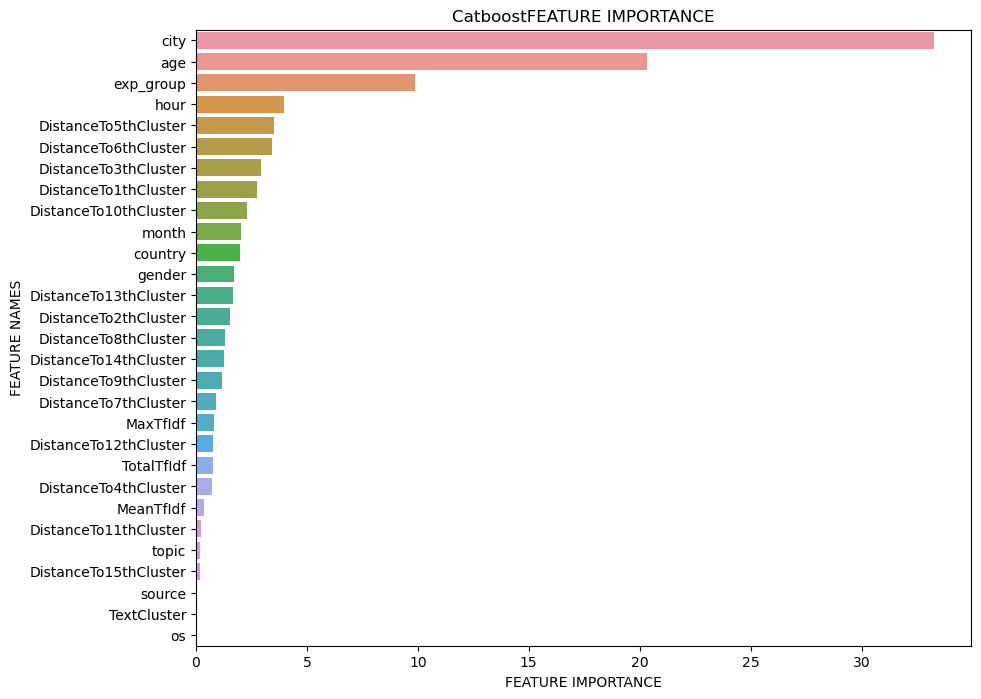

In [21]:
### Из любопытства посмотрим на feature_importance

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

plot_feature_importance(catboost.feature_importances_,X_train.columns,'Catboost')